In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


activities_df = pd.read_csv('data/activities_small.csv', encoding='utf-8')
zero_dist_mask = activities_df['distance'] > 0
activities_df = activities_df[zero_dist_mask]
activities_df.drop('index', 1, inplace=True)
runs_df = activities_df[activities_df.type == 'Run']
rides_df = activities_df[activities_df.type == 'Ride']

In [3]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 0 to 1617
Data columns (total 39 columns):
id                        1585 non-null int64
name                      1585 non-null object
distance                  1585 non-null float64
moving_time               1585 non-null float64
elapsed_time              1585 non-null float64
total_elevation_gain      1585 non-null float64
type                      1585 non-null object
start_date                1585 non-null object
start_date_local          1585 non-null object
timezone                  1585 non-null object
achievement_count         1585 non-null int64
kudos_count               1585 non-null int64
comment_count             1585 non-null int64
athlete_count             1585 non-null int64
photo_count               1585 non-null int64
total_photo_count         1585 non-null int64
trainer                   1585 non-null bool
commute                   1585 non-null bool
manual                    1585 non-null bool
private  

Let us focus on the rides dataframe. First lets get out only activities in Colorado. This data frame is relatively small and consists of mostly my ride history. I will have way more once I have scraped more. These are just activities immediately available to me via the strava api.

In [4]:
co_mask = rides_df['state'] == 'Colorado'
rides_co_df = rides_df[co_mask].reset_index(drop=True)
rides_co_df.shape

(676, 39)

Now it's time to make clusters of rides with same general starting latitude and longitude, ending latitude and longitude, distance and total elevation gain.

In [5]:
X = rides_co_df[['distance', 'total_elevation_gain', 'start_lat', 'start_lng', 'end_lat', 'end_lng']].values

In [6]:
k=10

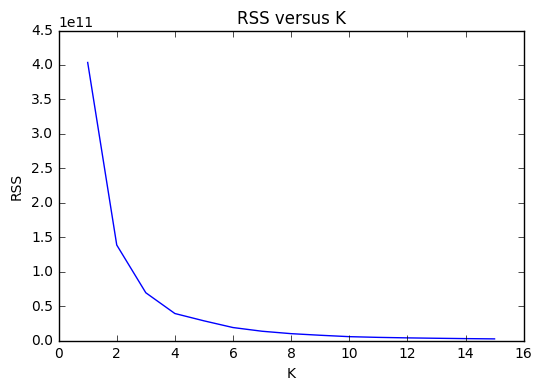

In [7]:
from sklearn.cluster import KMeans
ncluster_list = range(1,16)

def kmean_score(nclust):
    km = KMeans(nclust)
    km.fit(X)
    rss = -km.score(X)
    return rss
scores = [kmean_score(i) for i in range(1,16)]
plt.plot(range(1,16), scores)
plt.xlabel('K')
plt.ylabel('RSS')
plt.title('RSS versus K')
plt.show()

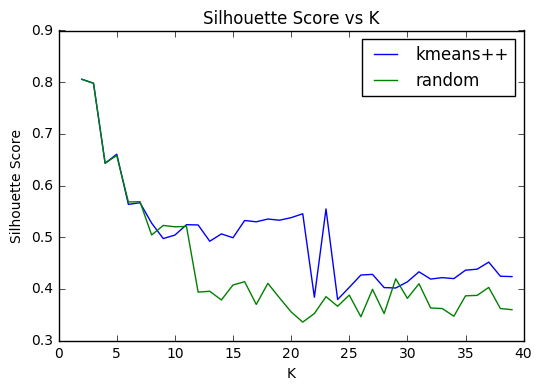

In [9]:
X = StandardScaler().fit_transform(X)
n_samples, n_features = X.shape
def get_silhouette_score(estimator):
    km = estimator
    km.fit(X)
    sil_avg = metrics.silhouette_score(X, km.labels_)
    return sil_avg

def get_estimators(n):
    estimators = [KMeans(init='k-means++', n_clusters=n, n_init=10),
                   KMeans(init='random', n_clusters=n, n_init=10)]
    return estimators

scores_arr = []
for n in range(2, 40):
    sil_scores = [get_silhouette_score(estimator) for estimator in get_estimators(n)]
    scores_arr.append(sil_scores)

plt.plot(range(2, 40), np.array(scores_arr)[:, 0])
plt.plot(range(2, 40), np.array(scores_arr)[:, 1])    
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs K')
plt.legend(['kmeans++', 'random'])
plt.show()


This method of evaluating the number of clusters always leads to improbable numbers of clusters. With 676 rides in the dataframe(most being mine) it is to be expected that there should be more than 12-16 rides which is number i get which has the silhoutte score on average.

In [134]:
X

array([[ 0.69237782,  2.78091149,  0.11910479, -0.20477101,  0.1185731 ,
        -0.20469834],
       [ 1.81448328,  0.56586413,  0.03160451, -0.19364974,  0.02801521,
        -0.19357506],
       [ 1.06320805,  0.15525636,  0.03452119, -0.19364974,  0.03093643,
        -0.19357506],
       ..., 
       [ 0.29402533, -0.63523343, -1.96631853, -0.69781393, -1.97302199,
        -0.69741844],
       [ 2.2848259 , -0.56707812,  0.02577116, -0.19159024,  0.02509399,
        -0.19151519],
       [ 0.56330068,  0.46530713,  0.01993781, -0.19982822,  0.04262132,
        -0.18904335]])

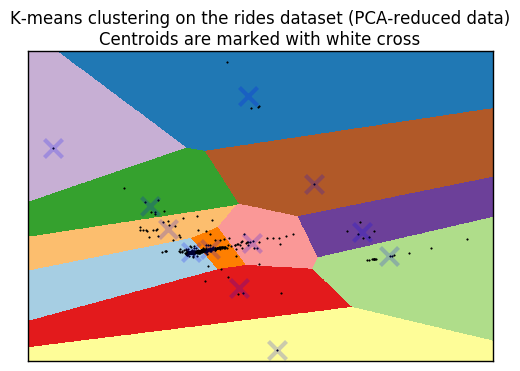

In [10]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=12, n_init=10).fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            cmap='prism', zorder=10, alpha=.2)
plt.title('K-means clustering on the rides dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()